In [1]:
import numpy as np
import pydicom
import nibabel as nib
import os
import cv2
import matplotlib.pyplot as plt
import pandas as pd
from scipy.ndimage.measurements import label
from matplotlib.collections import LineCollection

In [2]:
def preprocessTotalSegImg(img_path):

    img=nib.load(img_path)
    img=img.get_fdata()
    img1=np.zeros((220,220,380))
    for i in range(380):
        img_i=cv2.resize(img[70:442,70:442,379-i],(220,220))
        for j in range(220):
            img1[:,j,i]=img_i[j,:]
    img1=cv2.flip(img1,0)
    img1=np.round(img1,1)
    return(img1)

def readDcmPet(pathToDcmFolder):

    times=[]
    locs=[]
    for i in range(len(os.listdir(pathToDcmFolder))):
        file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
        ds=pydicom.dcmread(file)
        times.append(ds.AcquisitionTime)
        locs.append(ds.SliceLocation)
    uniTimes=np.sort(np.unique(np.array(times)))
    uniLocs=np.sort(np.unique(np.array(locs)))
    img4d=np.zeros((220,220,380,24))
    for k in range(24):
        for i in range(len(os.listdir(pathToDcmFolder))):
            if times[i]==uniTimes[k]:
                file='{}/{}'.format(pathToDcmFolder,os.listdir(pathToDcmFolder)[i])
                ds=pydicom.dcmread(file)
                for j in range(len(uniLocs)):
                    if uniLocs[j]==locs[i]:
                        img4d[:,:,j,k]=cv2.resize(ds.pixel_array*ds[0x0028, 0x1053].value,(220,220))+ds[0x0028, 0x1052].value
    return(img4d)

def readDcmCt(ctfilepath):

    ctlocs=[]
    for i in range(len(os.listdir(ctfilepath))):
        file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
        if file[-4:]=='.dcm':
            ds=pydicom.dcmread(file)
            ctlocs.append(ds.SliceLocation)
    ctUniLocs=np.sort(np.unique(np.array(ctlocs)))
    ctImg=np.zeros((512,512,380))
    for i in range(len(os.listdir(ctfilepath))):
        file='{}/{}'.format(ctfilepath,os.listdir(ctfilepath)[i])
        if file[-4:]=='.dcm':
            ds=pydicom.dcmread(file)
            for j in range(len(ctUniLocs)):
                if ctUniLocs[j]==ctlocs[i]:
                    ctImg[:,:,j]=ds.pixel_array
    ctImg1=np.zeros((220,220,380))
    for i in range(380):
        ctImg1[:,:,i]=cv2.resize(ctImg[70:442,70:442,i],(220,220))
    return(ctImg1)

def get_all_edges(bool_img):
    """
    Get a list of all edges (where the value changes from True to False) in the 2D boolean image.
    The returned array edges has he dimension (n, 2, 2).
    Edge i connects the pixels edges[i, 0, :] and edges[i, 1, :].
    Note that the indices of a pixel also denote the coordinates of its lower left corner.
    """
    edges = []
    ii, jj = np.nonzero(bool_img)
    for i, j in zip(ii, jj):
        # North
        if j == bool_img.shape[1]-1 or not bool_img[i, j+1]:
            edges.append(np.array([[i, j+1],
                                   [i+1, j+1]]))
        # East
        if i == bool_img.shape[0]-1 or not bool_img[i+1, j]:
            edges.append(np.array([[i+1, j],
                                   [i+1, j+1]]))
        # South
        if j == 0 or not bool_img[i, j-1]:
            edges.append(np.array([[i, j],
                                   [i+1, j]]))
        # West
        if i == 0 or not bool_img[i-1, j]:
            edges.append(np.array([[i, j],
                                   [i, j+1]]))

    if not edges:
        return np.zeros((0, 2, 2))
    else:
        return np.array(edges)


def close_loop_edges(edges):
    """
    Combine the edges defined by 'get_all_edges' to closed loops around objects.
    If there are multiple disconnected objects a list of closed loops is returned.
    Note that it's expected that all the edges are part of exactly one loop (but not necessarily the same one).
    """

    loop_list = []
    while edges.size != 0:

        loop = [edges[0, 0], edges[0, 1]]  # Start with first edge
        edges = np.delete(edges, 0, axis=0)

        while edges.size != 0:
            # Get next edge (=edge with common node)
            ij = np.nonzero((edges == loop[-1]).all(axis=2))
            if ij[0].size > 0:
                i = ij[0][0]
                j = ij[1][0]
            else:
                loop.append(loop[0])
                # Uncomment to to make the start of the loop invisible when plotting
                # loop.append(loop[1])
                break

            loop.append(edges[i, (j + 1) % 2, :])
            edges = np.delete(edges, i, axis=0)

        loop_list.append(np.array(loop))

    return loop_list

def plot_outlines(bool_img, ax=None, **kwargs):
    if ax is None:
        ax = plt.gca()
    edges = get_all_edges(bool_img=bool_img)
    edges = edges - 0.5  # convert indices to coordinates; TODO adjust according to image extent
    outlines = close_loop_edges(edges=edges)
    cl = LineCollection(outlines, **kwargs)
    ax.add_collection(cl)

def findOrganBox(img,j):

    #create another image matrix where the values within the greatest connected component of the target are 1 and the others are 0
    img1=np.zeros((img.shape))
    structure=np.ones((3,3,3),dtype=int)
    labeled, ncomponents = label(np.array(img==j,dtype=int),structure)
    u1=[]
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        u1.append(np.sum(img0))
    u=np.argmax(u1)+1
    img1+=np.array(labeled==u,dtype=int)
    #find the smallest rectangle containing the greatest connected component of the target by studying the maximums
    k5=0
    while(np.max(img1[:,:,k5])==0):
        k5+=1
    k6=k5
    while((np.max(img1[:,:,k6])>0) & (k6<379)):
        k6+=1
    k3=0
    while(np.max(img1[:,k3,k5:k6])==0):
        k3+=1
    k4=k3
    while((np.max(img1[:,k4,k5:k6])>0) & (k4<219)):
        k4+=1
    k1=0
    while(np.max(img1[k1,k3:k4,k5:k6])==0):
        k1+=1
    k2=k1
    while((np.max(img1[k2,k3:k4,k5:k6])>0) & (k2<219)):
        k2+=1
    arr=img1[k1:k2,k3:k4,k5:k6]
    voxelsInComponent=np.sum(arr)
    return(arr,k1,k2,k3,k4,k5,k6,voxelsInComponent)

def organTACInfo(img4d,arr,k1,k2,k3,k4,k5,k6):

    arr1=arr.astype('float')
    arr1[arr1==0]=np.nan
    arrayForTACInfo=np.zeros((4,24))
    for i in range(24):
        segmentOnly=img4d[k1:k2,k3:k4,k5:k6,i]*arr1
        arrayForTACInfo[0,i]=np.nanmean(segmentOnly)
        arrayForTACInfo[1,i]=np.nanmedian(segmentOnly)
        arrayForTACInfo[2,i]=np.nanquantile(segmentOnly,0.75)
        arrayForTACInfo[3,i]=np.nanquantile(segmentOnly,0.9)       
    return(arrayForTACInfo)

In [10]:
studyCode='koveri0001'
files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
for i in files:
    if 'rest_ct_segmentations.nii' in i:
        img_path='D:/koveri/Data/{}/{}'.format(studyCode,i)
    if ('Rest' in i or 'rest' in i) and 'rest_ct_segmentations' not in i:
        pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,i,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,i))[0])
img=preprocessTotalSegImg(img_path)
#img4d=readDcmPet(pathToDcmFolder)
#ctfilepath='D:/koveri/Data/koveri0001/CT_3.0__Br36__5'
#ctImg=readDcmCt(ctfilepath)
img111=np.zeros((220,220,380,2))
structure=np.ones((3,3,3),dtype=int)
for j in range(2):
    labeled, ncomponents = label(np.array(img==[52,7][j],dtype=int),structure)
    u1=[]
    for u in range(1,ncomponents+1):
        img0=np.array(labeled==u,dtype=int)
        u1.append(np.sum(img0))
    u=np.argmax(u1)+1
    img111[:,:,:,j]=np.array(labeled==u,dtype=int)

In [ ]:
intervals=np.array(14*[5]+3*[10]+3*[20]+4*[30])
t=np.zeros(24)
for i in range(24):
    t[i]=np.sum(intervals[0:(i+1)])
t[15]

In [ ]:
imgd1=img4d[:,:,:,11]

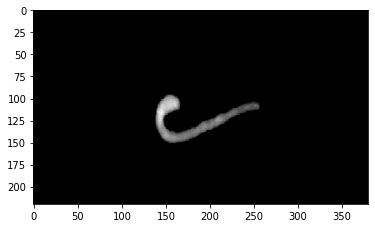

In [13]:
plt.imshow(np.mean(img111[:,:,:,0],axis=1),cmap='gray')

In [ ]:
plt.imshow(img111[100,:,:,0],cmap='gray')

In [ ]:
img1=cv2.resize(img1,(round(3/1.65*380),220))
img1=cv2.rotate(img1,cv2.cv2.ROTATE_90_CLOCKWISE)
img1=cv2.flip(img1,1)
img1=img1[150:600,0:220]/1000
plt.imshow(img1,cmap='gray_r')
plt.colorbar(label='kBq/ml')
j=0
img1=img111[140,:,:,j]
img1=cv2.resize(img1,(round(3/1.65*380),220))
img1=cv2.rotate(img1,cv2.cv2.ROTATE_90_CLOCKWISE)
img1=cv2.flip(img1,1)
img1=img1[150:600,0:220]
plot_outlines(img1.T, lw=2, color='black')
j=1
img1=img111[97,:,:,j]
img1=cv2.resize(img1,(round(3/1.65*380),220))
img1=cv2.rotate(img1,cv2.cv2.ROTATE_90_CLOCKWISE)
img1=cv2.flip(img1,1)
img1=img1[150:600,0:220]
plot_outlines(img1.T, lw=2, color='blue')
plt.axis('off')
fig=plt.gcf()
fig.savefig('ifig1.png',bbox_inches='tight')

In [18]:
for i in range(82,130):#skip over 19,27,75,76
    if i<9:
        studyCode='koveri000{}'.format(i+1)
    else:
        if i<99:
            studyCode='koveri00{}'.format(i+1)
        else:
            studyCode='koveri0{}'.format(i+1)
    files=os.listdir('D:/koveri/Data/{}'.format(studyCode))
    for j in files:
        if 'rest_ct_segmentations.nii' in j:
            img_path='D:/koveri/Data/{}/{}'.format(studyCode,j)
        if ('Rest' in j or 'rest' in j) and 'rest_ct_segmentations' not in j:
            if len(os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,j)))==1:
                pathToDcmFolder='D:/koveri/Data/{}/{}/{}'.format(studyCode,j,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,j))[0]) 
            else:
                pathToDcmFolder='D:/koveri/Data/{}/{}'.format(studyCode,j)
        if ('Stress' in j or 'stress' in j) and 'stress_ct_segmentations' not in j:
            if len(os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,j)))==1:
                pathToDcmFolder1='D:/koveri/Data/{}/{}/{}'.format(studyCode,j,os.listdir('D:/koveri/Data/{}/{}'.format(studyCode,j))[0])
            else:
                pathToDcmFolder1='D:/koveri/Data/{}/{}'.format(studyCode,j)   
    if os.path.exists(img_path) and os.path.exists(pathToDcmFolder) and os.path.exists(pathToDcmFolder1):
        img=preprocessTotalSegImg(img_path)
        img4d=readDcmPet(pathToDcmFolder)
        img4d1=readDcmPet(pathToDcmFolder1)
        array1=np.zeros((5,24))
        #aorta
        arr,k1,k2,k3,k4,k5,k6,vic=findOrganBox(img,52) 
        array1[1,:]=organTACInfo(img4d,arr,k1,k2,k3,k4,k5,k6)[0,:]
        array1[3,:]=organTACInfo(img4d1,arr,k1,k2,k3,k4,k5,k6)[0,:]
        array1[0,0]=vic
        #pancreas
        arr,k1,k2,k3,k4,k5,k6,vic=findOrganBox(img,7) 
        array1[2,:]=organTACInfo(img4d,arr,k1,k2,k3,k4,k5,k6)[0,:]
        array1[4,:]=organTACInfo(img4d1,arr,k1,k2,k3,k4,k5,k6)[0,:]
        array1[0,1]=vic
        df=pd.DataFrame(array1)
        df.to_csv('array1_{}.csv'.format(studyCode))